In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

import src.analysis.plotting_utils as pluto
from src.analysis.apogee_analysis import subgiants


In [4]:
sys.path.append("/home/daniel/")

In [5]:
import arya

AttributeError: 'Scatter' object has no attribute 'data'

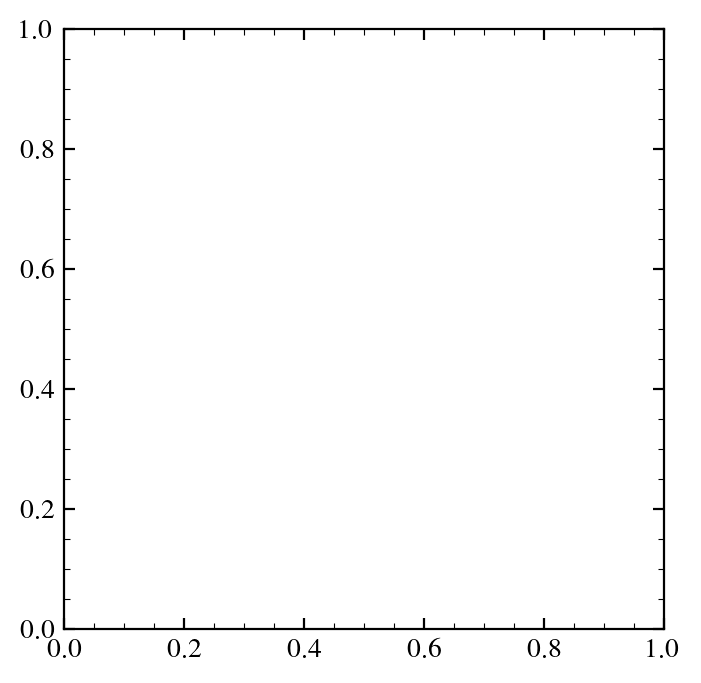

In [9]:
ha = subgiants["high_alpha"]

df = subgiants[~ha]

s = arya.Scatter(df["MG_H"], df["C_MG"], size=0.05)
s.label = "high $\\alpha$"

sp = s.subplot

df = subgiants[ha]
s1 = arya.Scatter(df["MG_H"], df["C_MG"], size=0.05, subplot=sp)
s1.label = "low $\\alpha$"


arya.Legend(sp)
sp.legend.ms = 2
sp.legend.color_labels  = True
#sp.legend.show_handles = False

sp.x.lim = (-0.6, 0.6)
sp.y.lim = (-0.5, 0.2)
sp.x.label = "[Mg/H]"
sp.y.label = "[C/Mg]"


In [8]:
s.mpl_scat.get_facecolor()

array([[0.00392157, 0.45098039, 0.69803922, 1.        ]])